In [33]:
import numpy as np 
import pandas as pd 
import pickle

import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import xgboost
from xgboost import XGBRegressor, plot_importance 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [2]:
with open('DATA_ENG_HOUSING/data/closed_listings_cleaned.pickle', 'rb') as read_file:
    df = pickle.load(read_file)
df.head()

,property_id,listing_id,status,list_date,list_price,description.sold_price,description.year_built,description.baths_3qtr,description.sold_date,description.baths_full,...,description.beds,location.address.postal_code,location.address.state,location.address.coordinate.lon,location.address.coordinate.lat,location.address.city,location.address.state_code,location.address.line,location.county.fips_code,location.county.name
0,2507173757,2930532060,sold,2021-06-15T15:05:55Z,1549000.0,1760000,1926,NaN,2021-07-16,2.0,...,3.0,90026,California,-118.276835,34.085110,Los Angeles,CA,3380 Descanso Dr,06037,Los Angeles
1,1681184474,2927976112,sold,2021-04-09T21:02:06Z,879000.0,850000,2008,NaN,2021-07-16,1.0,...,1.0,90015,California,-118.263194,34.040804,Los Angeles,CA,1155 S Grand Ave Apt 1807,06037,Los Angeles
2,2913082626,2930168949,sold,2021-06-05T00:02:43Z,849000.0,1016000,1912,NaN,2021-07-16,2.0,...,2.0,90018,California,-118.314134,34.023169,Los Angeles,CA,3563 S Gramercy Pl,06037,Los Angeles
3,1415870805,2931114156,sold,2021-06-29T16:08:40Z,1499000.0,1625000,1900,NaN,2021-07-16,3.0,...,5.0,90026,California,-118.267025,34.079045,Los Angeles,CA,1107 Waterloo St,06037,Los Angeles
4,2820635269,2929515091,sold,2021-05-20T16:00:15Z,395000.0,385000,1985,NaN,2021-07-16,1.0,...,2.0,90044,California,-118.295523,33.930572,Los Angeles,CA,11401 Berendo Ave Apt 6,06037,Los Angeles


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72662 entries, 0 to 243197
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   property_id                      72662 non-null  object 
 1   listing_id                       72662 non-null  object 
 2   status                           72662 non-null  object 
 3   list_date                        72661 non-null  object 
 4   list_price                       72662 non-null  float64
 5   description.sold_price           72662 non-null  int64  
 6   description.year_built           72662 non-null  int64  
 7   description.baths_3qtr           3825 non-null   float64
 8   description.sold_date            72662 non-null  object 
 9   description.baths_full           71011 non-null  float64
 10  description.baths_half           19044 non-null  float64
 11  description.lot_sqft             66486 non-null  float64
 12  description.sqft 

In [4]:
df['price_change'] = 100*(df['description.sold_price'] - df['list_price'])/df['list_price']

In [5]:
#Remove extreme values
df = df[df['price_change'] <= 100]
df = df[df['description.type'] != 'farm']  #This type of property if out of our analytic scope
df = df[df['description.sqft'] <= 5000]
df = df[df['description.lot_sqft'] < 100000]
df = df[df['description.sold_price'] <  10000000 ] 

In [6]:
#randomly sample and create a pairplot
sample_df = df.sample(n = 1000, replace = False)

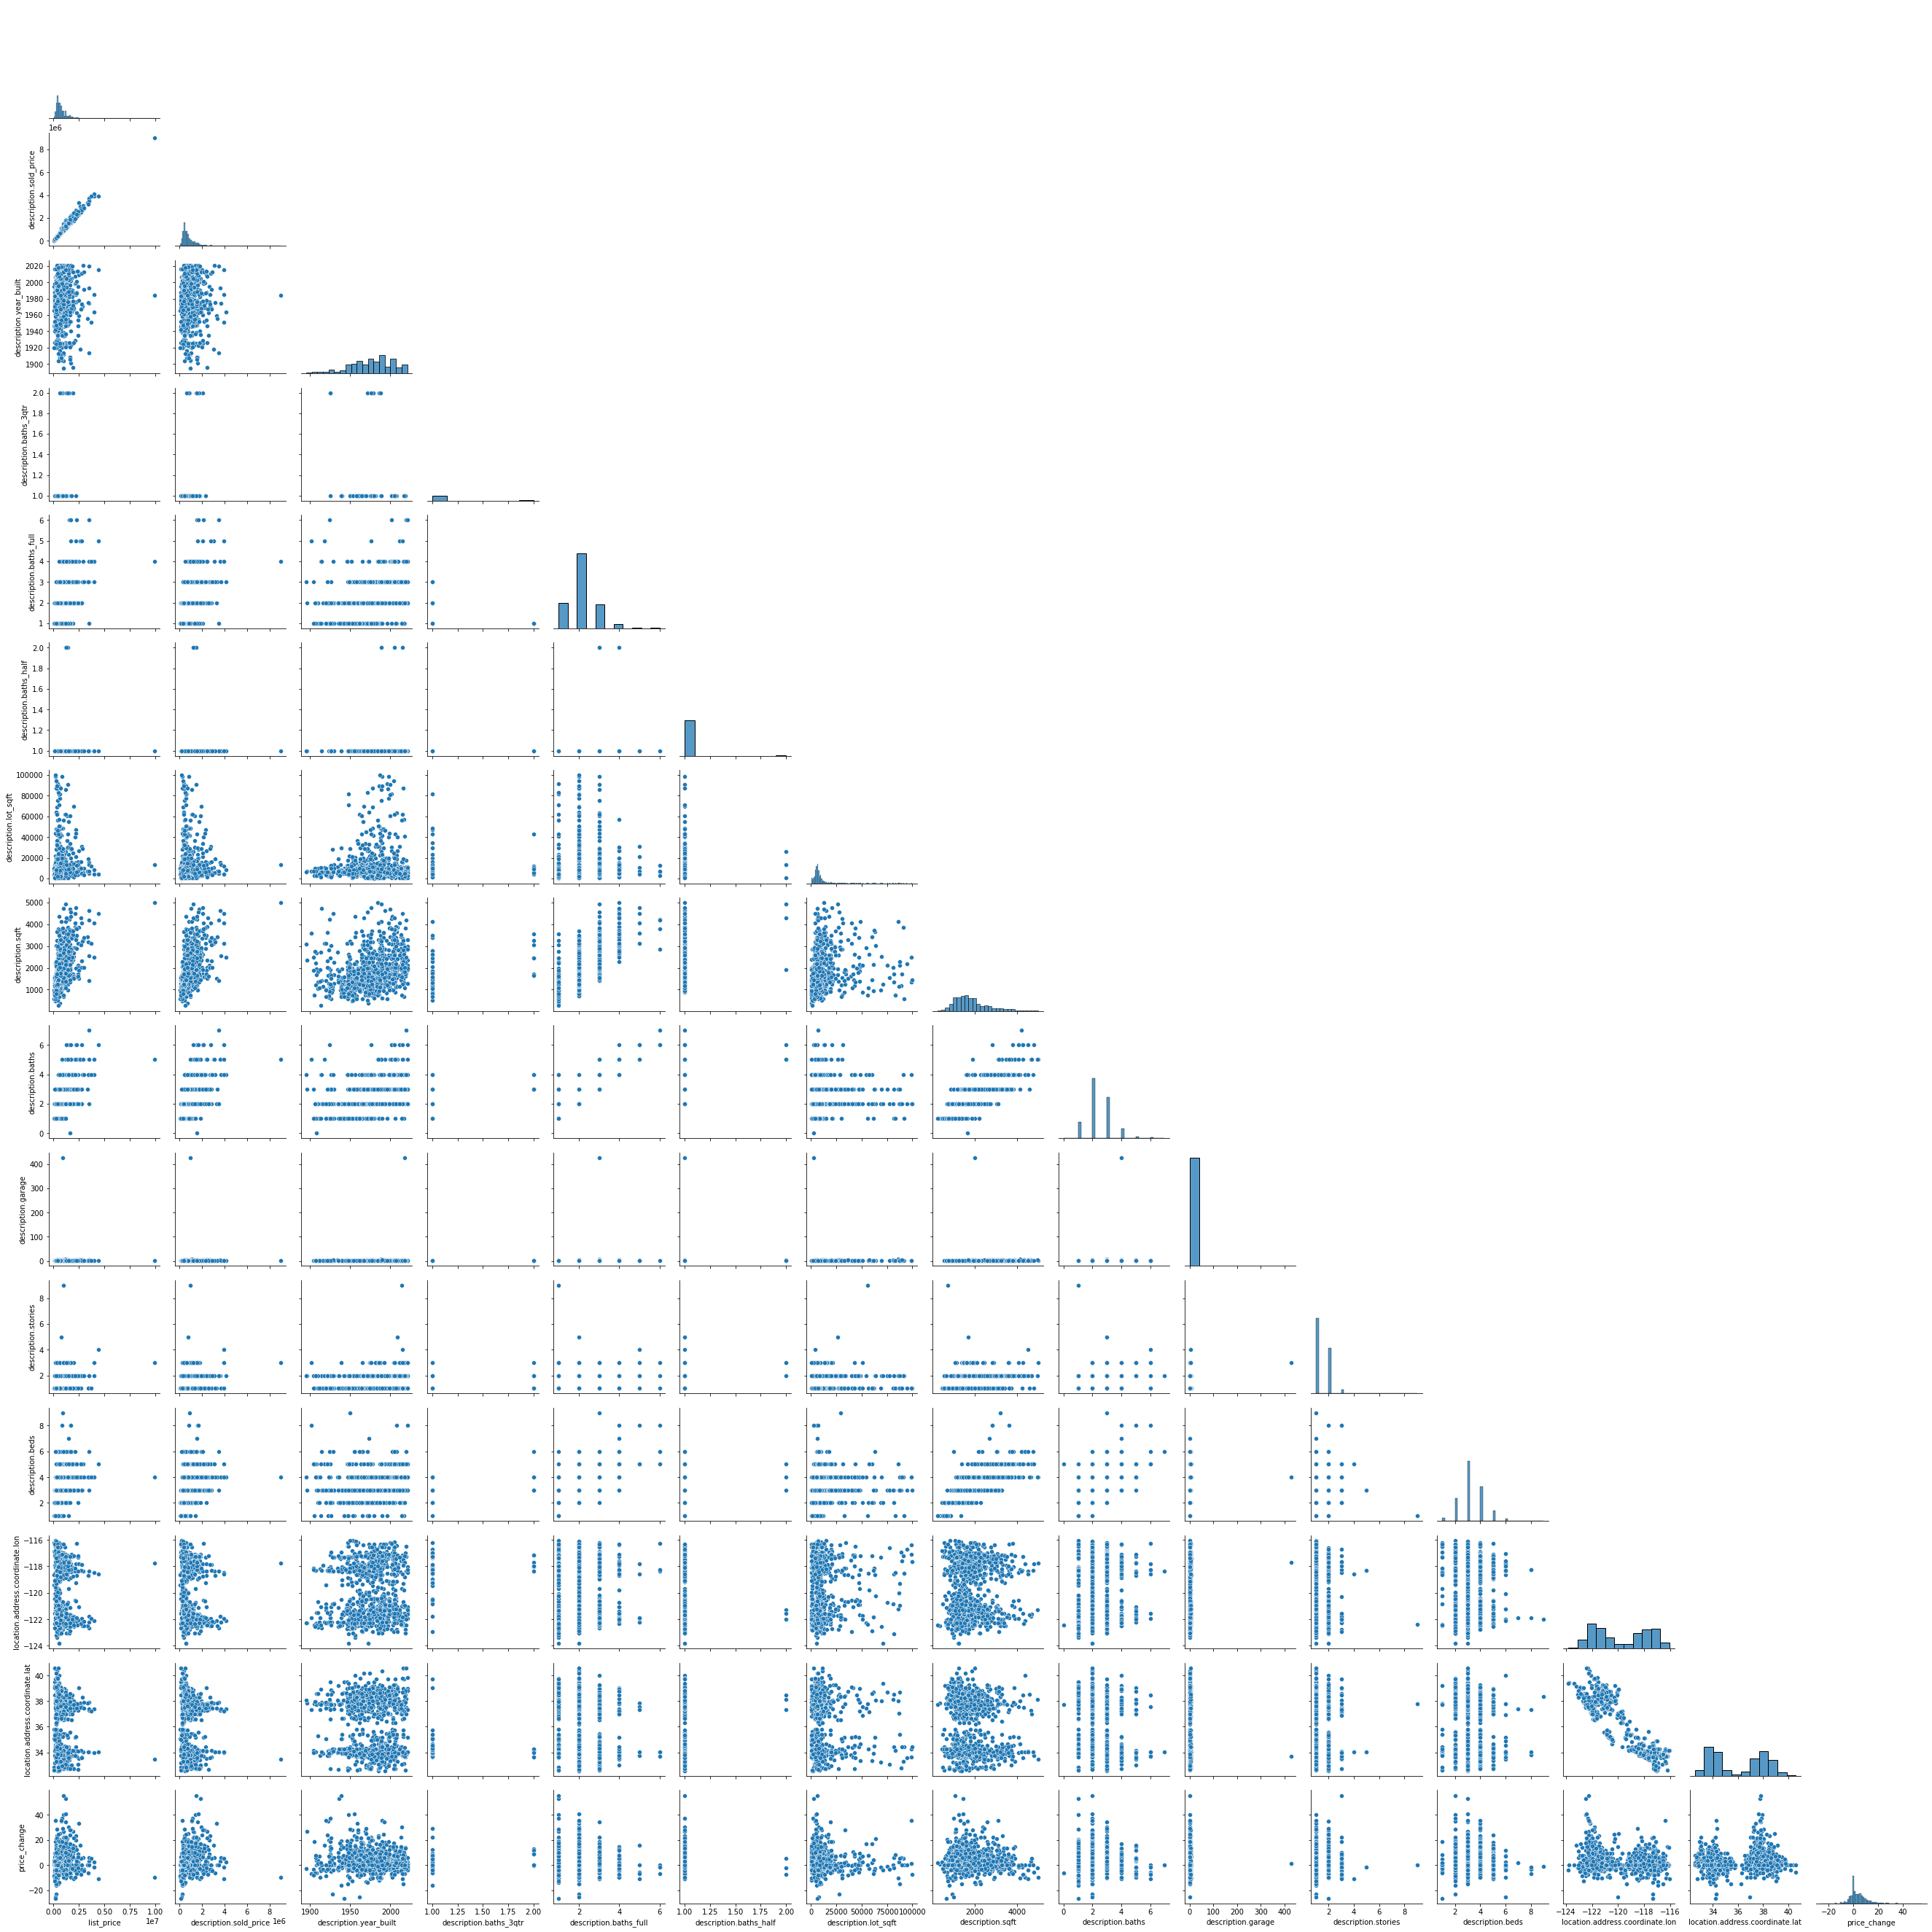

In [7]:
sns.pairplot(sample_df, corner=True)

In [8]:
#Remove unuseful columns
df.drop(columns = ['location.address.coordinate.lon','location.address.coordinate.lat','location.address.state','location.address.state_code', 'location.address.line','description.sold_date'], inplace = True)

In [9]:
df.describe()

,list_price,description.sold_price,description.year_built,description.baths_3qtr,description.baths_full,description.baths_half,description.lot_sqft,description.sqft,description.baths,description.garage,description.stories,description.beds,price_change
count,5.980000e+04,5.980000e+04,59800.000000,3237.000000,58381.000000,15447.000000,59800.000000,59800.000000,58752.000000,49374.000000,56002.000000,58939.000000,59800.000000
mean,8.334807e+05,8.705144e+05,1976.739114,1.203275,2.128124,1.022723,12293.299114,1863.888512,2.448393,2.234354,1.475608,3.263221,4.164238
std,7.080895e+05,7.292404e+05,26.239634,0.519771,0.801908,0.175368,15780.403068,791.988068,0.936745,29.316237,0.908279,1.038327,8.199701
min,1.000000e+04,1.850000e+02,1801.000000,1.000000,1.000000,1.000000,1.000000,100.000000,0.000000,1.000000,1.000000,0.000000,-99.902157
25%,4.250000e+05,4.400000e+05,1959.000000,1.000000,2.000000,1.000000,5362.000000,1296.000000,2.000000,2.000000,1.000000,3.000000,0.000000
50%,6.377250e+05,6.580000e+05,1979.000000,1.000000,2.000000,1.000000,7210.000000,1687.000000,2.000000,2.000000,1.000000,3.000000,2.512814
75%,9.699600e+05,1.025000e+06,1998.000000,1.000000,2.000000,1.000000,10890.000000,2263.250000,3.000000,2.000000,2.000000,4.000000,7.550380
max,1.249500e+07,9.971257e+06,2021.000000,11.000000,9.000000,6.000000,99999.000000,5000.000000,12.000000,6500.000000,42.000000,45.000000,87.050360


In [10]:
df_corr = df.corr()
df_corr

,list_price,description.sold_price,description.year_built,description.baths_3qtr,description.baths_full,description.baths_half,description.lot_sqft,description.sqft,description.baths,description.garage,description.stories,description.beds,price_change
list_price,1.000000,0.990394,-0.049880,0.272483,0.413858,0.112100,0.037278,0.527568,0.475348,0.001504,0.171081,0.301693,0.040055
description.sold_price,0.990394,1.000000,-0.065725,0.269175,0.402973,0.106593,0.026666,0.515163,0.462497,0.000954,0.164792,0.299906,0.151496
description.year_built,-0.049880,-0.065725,1.000000,0.005851,0.325755,-0.021908,0.077748,0.304608,0.375954,-0.006011,0.178941,0.171470,-0.108963
description.baths_3qtr,0.272483,0.269175,0.005851,1.000000,0.006274,0.073798,0.023819,0.281029,0.443840,0.013049,0.106085,0.224957,-0.041440
description.baths_full,0.413858,0.402973,0.325755,0.006274,1.000000,0.098524,0.072843,0.727952,0.824107,0.125985,0.199623,0.610318,-0.046670
description.baths_half,0.112100,0.106593,-0.021908,0.073798,0.098524,1.000000,0.068076,0.137441,0.302190,0.010255,0.027347,0.116408,-0.049185
description.lot_sqft,0.037278,0.026666,0.077748,0.023819,0.072843,0.068076,1.000000,0.119637,0.064055,0.002219,0.058266,-0.023515,-0.100745
description.sqft,0.527568,0.515163,0.304608,0.281029,0.727952,0.137441,0.119637,1.000000,0.781851,0.014582,0.224565,0.663760,-0.062261
description.baths,0.475348,0.462497,0.375954,0.443840,0.824107,0.302190,0.064055,0.781851,1.000000,0.126972,0.286159,0.591637,-0.051604
description.garage,0.001504,0.000954,-0.006011,0.013049,0.125985,0.010255,0.002219,0.014582,0.126972,1.000000,0.046823,0.118206,-0.006571


### Base Model

In [252]:
features_base = ['description.year_built','description.baths_3qtr','description.baths_full','description.baths_half',
                'description.lot_sqft','description.sqft','description.baths','description.garage',
                'description.stories','description.beds']

In [253]:
X = df[features_base]
y = df.iloc[:, 5]

In [254]:
X = X.fillna(0)

In [255]:
#test/train split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 40)

In [256]:
X_train = X_train[features_base]
X_test = X_test[features_base]
X_val = X_val[features_base]

In [257]:
#fit base model
lr_model_base = LinearRegression()
lr_model_base.fit(X_train, y_train)

#Scores
train_score = lr_model_base.score(X_train, y_train)
test_score = lr_model_base.score(X_test, y_test)

#Adj R2
adjusted_r2 = 1 - (1-lr_model_base.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [258]:
#print outputs
print('\nTrain R^2 score was:', train_score)
print('\nValidation R^2 score was:', test_score)
print('\nValidation adjusted R^2 was:',adjusted_r2)
print('\nFeature coefficient results: \n')
for feature, coef in zip(X_train.columns, lr_model_base.coef_):
    print(feature, ':', f'{coef:.2f}')


Train R^2 score was: 0.360141464349214

Validation R^2 score was: 0.3521534391234119

Validation adjusted R^2 was: 0.3516112627397173

Feature coefficient results: 

description.year_built : -8416.02
description.baths_3qtr : 10185.02
description.baths_full : 20384.67
description.baths_half : 37286.08
description.lot_sqft : -1.24
description.sqft : 441.16
description.baths : 180253.35
description.garage : -147.38
description.stories : 20264.28
description.beds : -68497.41


#### Final Model

In [310]:
city_ct = df.groupby("location.address.city")["listing_id"].count().reset_index()
city_ct.sort_values(by = 'listing_id', ascending= False)

,location.address.city,listing_id
525,Los Angeles,1827
825,San Jose,1291
805,Sacramento,1242
818,San Diego,1182
918,Stockton,601
...,...,...
856,Santa Rosa Valley,1
857,Santa Ynez,1
858,Santa Ysabel,1
229,Davenport,1


In [311]:
# Remove citices which have less than 50 sold properties, because the sample size of those cities are too small to use
city_to_keep = city_ct[city_ct['listing_id']>= 50]

In [312]:
city_to_keep.sort_values(by = 'listing_id', ascending = True)
city_to_keep = city_to_keep['location.address.city'].tolist()

In [313]:
df2 = df[df['location.address.city'].isin(city_to_keep)]

In [314]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49661 entries, 0 to 243197
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   49661 non-null  object 
 1   listing_id                    49661 non-null  object 
 2   status                        49661 non-null  object 
 3   list_date                     49660 non-null  object 
 4   list_price                    49661 non-null  float64
 5   description.sold_price        49661 non-null  int64  
 6   description.year_built        49661 non-null  int64  
 7   description.baths_3qtr        2610 non-null   float64
 8   description.baths_full        48528 non-null  float64
 9   description.baths_half        13122 non-null  float64
 10  description.lot_sqft          49661 non-null  float64
 11  description.sqft              49661 non-null  float64
 12  description.baths             48832 non-null  float64
 13  

In [315]:
features = ['list_price','description.year_built','description.baths_3qtr','description.baths_full','description.baths_half',
                'description.lot_sqft','description.sqft','description.baths','description.garage',
                'description.stories','description.beds', 'description.type','location.address.city']

In [316]:
X = df2[features]
y = df2.iloc[:, 5]

In [317]:
X = X.fillna(0)

In [318]:
#test/train split
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 40)

In [319]:
#Scale continuous features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['list_price','description.year_built','description.baths_3qtr','description.baths_full',
                                                    'description.baths_half','description.lot_sqft','description.sqft','description.baths',
                                                    'description.garage','description.stories','description.beds']])

# Apply the same scaler to val set
X_val_scaled = scaler.transform(X_val[['list_price','description.year_built','description.baths_3qtr','description.baths_full',
                                              'description.baths_half','description.lot_sqft','description.sqft','description.baths',
                                              'description.garage','description.stories','description.beds']])

In [320]:
city_dummies_train = pd.get_dummies(X_train['location.address.city'])
city_dummies_train_arr = np.array(city_dummies_train)

In [321]:
city_dummies_val = pd.get_dummies(X_val['location.address.city'])
city_dummies_val_arr = np.array(city_dummies_val)

In [322]:
type_dummies_train = pd.get_dummies(X_train['description.type'])
type_dummies_train_arr = np.array(type_dummies_train)

In [323]:
type_dummies_val = pd.get_dummies(X_val['description.type'])
type_dummies_val_arr = np.array(type_dummies_val)

In [324]:
#Merge continuous features with dummies
X_train_scaled_all = np.concatenate((X_train_scaled, city_dummies_train_arr), axis = 1)
X_val_scaled_all = np.concatenate((X_val_scaled, city_dummies_val_arr), axis = 1)

In [325]:
#Merge continuous features with dummies
X_train_scaled_all = np.concatenate((X_train_scaled_all, type_dummies_train_arr), axis = 1)
X_val_scaled_all = np.concatenate((X_val_scaled_all, type_dummies_val_arr), axis = 1)

In [326]:
X, y = np.array(X_train_scaled_all), np.array(y_train)

In [330]:
len(X[0])

360

In [278]:
from sklearn.linear_model import LassoCV

In [279]:
#Cross Validation on training data
kf = KFold(n_splits=5, shuffle=True, random_state = 20)
cv_lm_r2s = [] #collect the validation results for both models

for train_ind, test_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_test, y_test = X[test_ind], y[test_ind] 
    
    #simple linear regression
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_test, y_test).round(3))
    


print(f'Simple scores: \t{cv_lm_r2s}')
print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')


Simple scores: 	[0.984, 0.91, 0.986, 0.984, 0.984]
Simple mean cv r^2: 0.970 +- 0.030


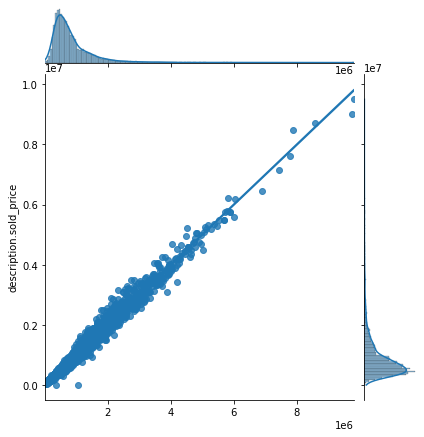

In [280]:
preds_val = lm.predict(X_val_scaled_all)

h = sns.jointplot(x=preds_val,y=y_val, kind='reg')

In [281]:
#Calculate RMSE

def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))


RMSE(y_val,preds_val)

84637.54020269832

### Prediction on the active listing

In [372]:
#import active listing and run the prediction
with open('DATA_ENG_HOUSING/data/df_final.pickle', 'rb') as read_file:
    df_final = pickle.load(read_file)

In [373]:
df_final = df_final[df_final['city'].isin(city_to_keep)]

In [374]:
df_final = df_final[(df_final['type'] != 'apartment') & (df_final['type'] != 'farm')]

In [375]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434312 entries, 907116 to 3384446
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   listing_id                434312 non-null  object 
 1   property_id               434312 non-null  object 
 2   status                    434312 non-null  object 
 3   list_date                 434312 non-null  object 
 4   list_price                434312 non-null  float64
 5   year_built                434312 non-null  float64
 6   baths                     432995 non-null  float64
 7   garage                    347697 non-null  float64
 8   stories                   407179 non-null  float64
 9   beds                      433611 non-null  float64
 10  type                      434312 non-null  object 
 11  postal_code               434312 non-null  object 
 12  address                   433017 non-null  object 
 13  city                      434312 non-n

In [376]:
features = ['list_price','year_built','description.baths_3qtr_x','description.baths_full_x','description.baths_half_x',
                'lot_sqft','sqft','baths','garage','stories','beds', 'type','city']

In [377]:
active_listings = df_final[features]
active_listings = active_listings.fillna(0)

In [378]:
#Create dummies
city_dummies = pd.get_dummies(active_listings['city'])
city_dummies_arr = np.array(city_dummies)

In [379]:
type_dummies = pd.get_dummies(active_listings['type'])
type_dummies_arr = np.array(type_dummies)

In [380]:
#Scale continuous features
scaler = StandardScaler()
X_active_scaled = scaler.fit_transform(active_listings[['list_price','year_built','description.baths_3qtr_x','description.baths_full_x',
                                                    'description.baths_half_x','lot_sqft','sqft','baths',
                                                    'garage','stories','beds']])


In [381]:
len(X_active_scaled[0])

11

In [382]:
#Merge continuous features with dummies
X_active_scaled_all = np.concatenate((X_active_scaled, type_dummies_arr), axis = 1)


In [383]:
X_active_scaled_all = np.concatenate((X_active_scaled_all, city_dummies_arr), axis = 1)

In [384]:
len(X_active_scaled_all[0])

360

In [385]:
X = np.array(X_active_scaled_all)

In [386]:
preds_active = lm.predict(X)

In [387]:
preds_active

array([4.36126286e+16, 8.58132000e+05, 4.36126286e+16, ...,
       4.36126286e+16, 4.36126286e+16, 4.36126286e+16])

In [388]:
df_final['pred_sold_price'] = preds_active

In [392]:
df_final['pred_price_chag'] = (df_final['pred_sold_price'] - df_final['list_price'])/df_final['list_price']

In [393]:
df_final.info()

,listing_id,property_id,status,list_date,list_price,year_built,baths,garage,stories,beds,...,year_built_sold,sold_date,lot_sqft_sold,sqft_sold,bath_sold,beds_sold,location.address.city_y,address_sold,pred_sold_price,pred_price_chag
907116,2931339032,2158559976,for_sale,2021-07-06,434950.0,1975.0,1.0,1.0,1.0,1.0,...,1975.0,2021-07-09,428195.0,653.0,1.0,1.0,San Diego,1775 Diamond St Unit 121,4.361263e+16,1.002704e+11
370636,2931803397,2652943692,for_sale,2021-07-15,499900.0,1988.0,2.0,NaN,1.0,2.0,...,1989.0,2021-06-26,NaN,1252.0,2.0,2.0,Yorba Linda,5215 Box Canyon Ct Unit 20H,8.581320e+05,7.166073e-01
2348749,2929560849,2211677120,for_sale,2021-05-21,1388000.0,2003.0,3.0,2.0,2.0,4.0,...,2002.0,2021-07-06,NaN,2387.0,3.0,4.0,Irvine,207 Tuberose,4.361263e+16,3.142120e+10
370635,2931803397,2652943692,for_sale,2021-07-15,499900.0,1988.0,2.0,NaN,1.0,2.0,...,1988.0,2021-07-01,NaN,1252.0,2.0,2.0,Yorba Linda,5265 Box Canyon Ct Unit 24A,8.581320e+05,7.166073e-01
370632,2931803397,2652943692,for_sale,2021-07-15,499900.0,1988.0,2.0,NaN,1.0,2.0,...,1989.0,2021-07-02,NaN,1252.0,2.0,2.0,Yorba Linda,5205 Box Canyon Ct Unit 19D,8.581320e+05,7.166073e-01
